<a href="https://colab.research.google.com/github/li0ne/graduation-thesis/blob/main/uwu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
#パラメータ
beta  = 0.98   # Discount factor
sigma = 0.6    # Weight on consumption utility(vs leisure)
w1, w2, w3 = 0.4, 1.2, 2.4
h0    = 1.0    # Initial human capital
kappa = 4.0    # Scale for training time cost
gamma = 1.7    # Exponent for training time cost
rho   = 0.7    # CRRA risk aversion coefficient
delta_s = 1.18          # Exogenous human capital bump after the training
delta_w = 1.22
mu_N = 0.69    # rate of people enrolled in vocational programs in Netherlands(OECD)
mu_J = 0.12    # rate of people enrolled in vocational programs in Japan

In [3]:
# Training efficiency: assume worker training is more efficient than student training
alpha_student = 1.0   # Human capital gain per unit training in period 1 (student)
alpha_worker  = 1.0   # Human capital gain per unit training in period 2 (worker), = alpha_student

In [4]:
# 定義関数
def training_time(e):
    """Training time cost (bounded so it never exceeds available time)."""
    return min(kappa * e**gamma, 0.9)

def u_consumption(C):
    """CRRA utility (positive domain only)."""
    if C <= 0:
        return -1e8
    return C**(1 - rho) / (1 - rho)

def u_leisure(M):
    """Log utility for leisure (positive domain only)."""
    if M <= 0:
        return -1e8
    return np.log(M)

In [5]:
# ======================
# Objective: Student training (e2=0)
# ======================
def objective_student(vars):
    e1, M1, M2, M3 = vars
    e2 = 0.0

    if M1 + training_time(e1) >= 1 or M2 + training_time(e2) >= 1:
        return 1e8

    l1 = 1 - M1 - training_time(e1)
    l2 = 1 - M2 - training_time(e2)
    l3 = 1 - M3

    # Human capital dynamics (compounded by delta_s)
    h_p1 = h0 * delta_s + alpha_student * e1
    h_p2 = h_p1 * delta_s
    h_p3 = h_p2 * delta_s

    C1, C2, C3 = w1 * h_p1 * l1, w2 * h_p2 * l2, w3 * h_p3 * l3
    U1 = sigma * u_consumption(C1) + (1 - sigma) * u_leisure(M1)
    U2 = sigma * u_consumption(C2) + (1 - sigma) * u_leisure(M2)
    U3 = sigma * u_consumption(C3) + (1 - sigma) * u_leisure(M3)

    return -(U1 + beta * U2 + beta**2 * U3)

# ======================
# Objective: Worker training (e1=0)
# ======================
def objective_worker(vars):
    e2, M1, M2, M3 = vars
    e1 = 0.0

    if M1 + training_time(e1) >= 1 or M2 + training_time(e2) >= 1:
        return 1e8

    l1 = 1 - M1 - training_time(e1)
    l2 = 1 - M2 - training_time(e2)
    l3 = 1 - M3

    # Human capital dynamics (compounded by delta_w)
    h_p1 = h0 * delta_w
    h_p2 = h_p1 * delta_w + alpha_worker * e2
    h_p3 = h_p2 * delta_w

    C1, C2, C3 = w1 * h_p1 * l1, w2 * h_p2 * l2, w3 * h_p3 * l3
    U1 = sigma * u_consumption(C1) + (1 - sigma) * u_leisure(M1)
    U2 = sigma * u_consumption(C2) + (1 - sigma) * u_leisure(M2)
    U3 = sigma * u_consumption(C3) + (1 - sigma) * u_leisure(M3)

    return -(U1 + beta * U2 + beta**2 * U3)

In [6]:
# ======================
# Solve both scenarios
# ======================
bounds_student = [(0, 1), (1e-3, 1-1e-3), (1e-3, 1-1e-3), (1e-3, 1-1e-3)]
bounds_worker  = [(0, 1), (1e-3, 1-1e-3), (1e-3, 1-1e-3), (1e-3, 1-1e-3)]
init_student = np.array([0.1, 0.1, 0.1, 0.1])
init_worker  = np.array([0.1, 0.1, 0.1, 0.1])

res_s = minimize(objective_student, init_student, bounds=bounds_student)
res_w = minimize(objective_worker, init_worker, bounds=bounds_worker)

if not res_s.success:
    raise RuntimeError("Optimization failed for student scenario")
if not res_w.success:
    raise RuntimeError("Optimization failed for worker scenario")

e1_s, M1_s, M2_s, M3_s = res_s.x
e2_w, M1_w, M2_w, M3_w = res_w.x


In [7]:
# ======================
# Compute resulting paths
# ======================
# Student training
h_p1_s = h0 * delta_s + alpha_student * e1_s
h_p2_s = h_p1_s * delta_s
h_p3_s = h_p2_s * delta_s

l1_s = 1 - M1_s - training_time(e1_s)
l2_s = 1 - M2_s
l3_s = 1 - M3_s

C1_s, C2_s, C3_s = w1*h_p1_s*l1_s, w2*h_p2_s*l2_s, w3*h_p3_s*l3_s
U1_s = sigma * u_consumption(C1_s) + (1 - sigma) * u_leisure(M1_s)
U2_s = sigma * u_consumption(C2_s) + (1 - sigma) * u_leisure(M2_s)
U3_s = sigma * u_consumption(C3_s) + (1 - sigma) * u_leisure(M3_s)
U_life_s = U1_s + beta*U2_s + beta**2*U3_s

# Worker training
h_p1_w = h0 * delta_w
h_p2_w = h_p1_w * delta_w + alpha_worker * e2_w
h_p3_w = h_p2_w * delta_w

l1_w = 1 - M1_w
l2_w = 1 - M2_w - training_time(e2_w)
l3_w = 1 - M3_w

C1_w, C2_w, C3_w = w1*h_p1_w*l1_w, w2*h_p2_w*l2_w, w3*h_p3_w*l3_w
U1_w = sigma * u_consumption(C1_w) + (1 - sigma) * u_leisure(M1_w)
U2_w = sigma * u_consumption(C2_w) + (1 - sigma) * u_leisure(M2_w)
U3_w = sigma * u_consumption(C3_w) + (1 - sigma) * u_leisure(M3_w)
U_life_w = U1_w + beta*U2_w + beta**2*U3_w


In [8]:
# ======================
# Results summary
# ======================
print("=== Student training scenario ===")
print(f"Optimal e1 = {e1_s:.3f}")
print(f"Leisure (M1, M2, M3) = {M1_s:.3f}, {M2_s:.3f}, {M3_s:.3f}")
print(f"Lifetime utility = {U_life_s:.4f}")
print()

print("=== Worker training scenario ===")
print(f"Optimal e2 = {e2_w:.3f}")
print(f"Leisure (M1, M2, M3) = {M1_w:.3f}, {M2_w:.3f}, {M3_w:.3f}")
print(f"Lifetime utility = {U_life_w:.4f}")

=== Student training scenario ===
Optimal e1 = 0.122
Leisure (M1, M2, M3) = 0.453, 0.392, 0.326
Lifetime utility = 4.8475

=== Worker training scenario ===
Optimal e2 = 0.055
Leisure (M1, M2, M3) = 0.505, 0.382, 0.323
Lifetime utility = 4.9197


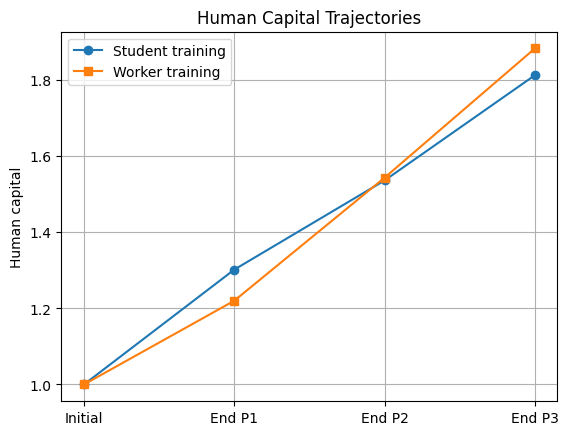

In [9]:
# ======================
# Visualization (optional)
# ======================
periods = ["Initial", "End P1", "End P2", "End P3"]
h_seq_student = [h0, h_p1_s, h_p2_s, h_p3_s]
h_seq_worker  = [h0, h_p1_w, h_p2_w, h_p3_w]

plt.plot(periods, h_seq_student, marker="o", label="Student training")
plt.plot(periods, h_seq_worker, marker="s", label="Worker training")
plt.ylabel("Human capital")
plt.legend()
plt.title("Human Capital Trajectories")
plt.grid(True)
plt.show()